# [Take-home Assessment] Food Crisis Early Warning 

Welcome to the assessment. You will showcase your modeling and research skills by investigating news articles (in English and Arabic) as well as a set of food insecurity risk factors. 

We suggest planning to spend **~6–8 hours** on this assessment. **Please submit your response by Monday, September 15th, 9:00 AM EST via email to dime_ai@worldbank.org**. Please document your code with comments and explanations of design choices. There is one question on reflecting upon your approach at the end of this notebook.

**Name:**  Jonas Nothnagel

**Email:** jonas.nothnagel@gmail.com

# Part 1: Technical Assessment


## Task:

We invite you to approach the challenge of understanding (and potentially predicting) food insecurity using the provided (limited) data. Your response should demonstrate how you tackle open-ended problems in data-scarce environments.

Some example questions to consider:
- What is the added value of geospatial data?
- How can we address the lack of ground-truth information on food insecurity levels?
- What are the benefits and challenges of working with multilingual data?
- ...

These are just guiding examples — you are free to explore any relevant angles to this topic/data.

**Note:** There is no single "right" approach. Instead, we want to understand how you approach and structure open-ended problems in data-scarce environments. Given the large number of applicants, we will preselect the most impressive and complete submissions. Please take effort in structuring your response, as selection will depend on its depth and originality.


## Provided Data:

1. **Risk Factors:** A file containing 167 risk factors (unigrams, bigrams, and trigrams) in the `english_keywords` column and an empty `keywords_arabic` column. A separate file with the mapping of English risk factors to pre-defined thematic cluster assignments.


2. **News Articles:** Two files containing one month of news articles from the Mashriq region:
   - `news-articles-eng.csv`
   - `news-articles-ara.csv`
   - **Note:** You may work on a sample subset during development.
   
   
3. **Geographic Taxonomy:** A file containing the names of the countries, provinces, and districts for the subset of Mashriq countries that is covered by the news articles. The files are a dictionary mapping from a key to the geographic name.
   - `id_arabic_location_name.pkl`
   - `id_english_location_name.pkl`
   - **Note:** Each unique country/province/district is assigned a key (e.g. `iq`,`iq_bg` and `iq_bg_1` for country Iraq, province Baghdad, and district 1 in Baghdad respectively).
   - The key of country names is a two character abbreviation as follows.
       - 'iq': 'Iraq'
       - 'jo': 'Jordan'
       - 'lb': 'Lebanon'
       - 'ps': 'Palestine'
       - 'sy': 'Syria'
       
   - The key of provinces is a two-character abbreviation of the country followed by two-character abbreviation of the province **`{country_abbreviation}_{province_abbreviation}`**, and the key of districts is **`{country_abbreviation}_{province_abbreviation}_{unique_number}`**.
       


## Submission Guidelines:

- **Code:** Follow best coding practices and ensure clear documentation. All notebook cells should be executed with outputs saved, and the notebook should run correctly on its own. Name your file **`solution_{FIRSTNAME}_{LASTNAME}.ipynb`**. If your solution relies on additional open-access data, either include it in your submission (e.g., as part of a ZIP file) or provide clear data-loading code/instructions as part of the nottebook. 
- **Report:** Submit a separate markdown file communicating your approach to this research problem. We expect you to detail the models, methods, or (additional) data you are using.

Good luck!


---

---

## Your Submission

In [44]:
# Import libraries 
import pandas as pd
import numpy as np
import pickle
import re
from typing import Dict, List, Tuple
import ast
from sklearn.metrics.pairwise import cosine_similarity
from thefuzz import fuzz
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import os
import matplotlib.dates as mdates 
import seaborn as sns   


Inspect the other notebooks in data_processing_notebook first to understand the data we are working with here.

In [46]:
# Load the processed and prepared data from the other notebooks into this final analysis notebook
df_en = pd.read_csv('new_data/english_news_tagged.csv')
df_ar = pd.read_csv('new_data/arabic_news_tagged.csv')
clusters_df = pd.read_excel('new_data/bilingual_clusters.xlsx')

print("NOTE, for the purpose of this demo, we are using a large subset (75000) of the data.")
print(df_en.shape)

NOTE, for the purpose of this demo, we are using a large subset (75000) of the data.
(75000, 32)


## Step 1: Assign Cluster to each of the news article 
- After this step we will have the final DataFrame that contains information from all given data sources: 

    i) articles, 
    ii) geographical tags, 
    iii) Cluster assignment.

- Clustering/Tagging articles was supposed to be done via simple keyword matching but the precision was very bad as many articles are completely unrelated to food insecurities but contain a few of these keywords. Thus we will embedd the keyword lists as well as the articles and find the most semantic similar one. We will find the score for each article to each cluster (which takes hours, so we will work with a small subset for development purpose) - I am also trying to utilise the keyword list by calculating a score of keyword density per 1000 words. Finally I will calculate a weighted score (65/35 weighting) of these both to have a way to filter for "relevant" articles. 

- Semantic Similarity is a bit tricky as some of the embedding vectors for cluster basically just consist of a few keywords. Note to myself: perhaps the keyword density should be weigthed higher.

- The challenge here is also the multilingual nature. THe best sentence transformer models do not work in Arabic and the multilingual models are weak on english (compared to the strong models in English). If we choose two different models we make the analysis on language not comparable anymore though. 

In [4]:
# using multi-lingual model
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
# english:
# all-MiniLM-L6-v2
# arabic:
# CAMeL-Lab/bert-base-arabic-camelbert-mix-ner

In [5]:
def _preprocess_clusters_df(clusters_df: pd.DataFrame) -> pd.DataFrame:
    """
    Safely parses string representations of lists in keyword columns into actual lists.
    """
    for col in ['english_keywords', 'arabic_keywords']:
        # Ensure the column exists and handle potential errors
        if col in clusters_df.columns:
            clusters_df[col] = clusters_df[col].apply(
                lambda x: ast.literal_eval(x) if isinstance(x, str) else x
            )
    return clusters_df

def get_all_cluster_similarities(
    text_embedding: np.ndarray,
    cluster_embeddings: Dict[str, np.ndarray]
) -> Dict[str, float]:
    """
    Calculates the cosine similarity of a text embedding against all cluster embeddings.
    
    Returns:
        A dictionary of {cluster_name: similarity_score}
    """
    similarities = {}
    text_embedding_reshaped = text_embedding.reshape(1, -1)

    for cluster_name, cluster_embedding in cluster_embeddings.items():
        cluster_embedding_reshaped = cluster_embedding.reshape(1, -1)
        similarity = cosine_similarity(text_embedding_reshaped, cluster_embedding_reshaped)[0][0]
        similarities[cluster_name] = round(float(similarity), 4)
        
    return similarities

def calculate_keyword_density(text: str, all_keywords: List[str]) -> float:
    """
    Calculates the density of keywords in a text.
    
    Returns:
        Keyword density score (occurrences per 1000 words).
    """
    if not text or not all_keywords:
        return 0.0

    text_lower = text.lower()
    
    word_count = len(re.findall(r'\w+', text_lower))
    if word_count == 0:
        return 0.0
    
    match_count = 0
    unique_keywords = set(kw.lower() for kw in all_keywords)
    for keyword in unique_keywords:
        match_count += len(re.findall(re.escape(keyword), text_lower))
    
    density = (match_count / word_count) * 1000
    
    return density


def assign_relevance_score_to_articles(
    articles_df: pd.DataFrame,
    clusters_df: pd.DataFrame,
    language: str,
    model 
) -> pd.DataFrame:
    """
    Assigns a relevance score to articles based on semantic similarity to all clusters
    and keyword density.
    """
    lang_map = {
        'english': {'cluster': 'cluster_english', 'keywords': 'english_keywords'},
        'arabic': {'cluster': 'cluster_arabic', 'keywords': 'arabic_keywords'},
    }
    cluster_col = lang_map[language]['cluster']
    keywords_col = lang_map[language]['keywords']
    
    # Pre-process clusters
    clusters_df_processed = _preprocess_clusters_df(clusters_df.copy())

    # Create cluster embeddings
    print(f"Computing embeddings for {language} clusters...")
    cluster_embeddings = {}
    for _, row in clusters_df_processed.iterrows():
        cluster_name = row[cluster_col]
        keywords = row[keywords_col]
        if keywords and isinstance(keywords, list):
            keyword_embeddings = model.encode(keywords)
            cluster_embeddings[cluster_name] = np.mean(keyword_embeddings, axis=0)
        else:
            cluster_embeddings[cluster_name] = np.zeros(model.get_sentence_embedding_dimension())
    print("Cluster embeddings computed.")

    # Prepare a flat list of all keywords for the density function
    all_keywords = [kw for sublist in clusters_df_processed[keywords_col] for kw in sublist]

    # Combine title and body for full text analysis
    articles_df['full_text'] = articles_df['title'].fillna('') + ' ' + articles_df['body'].fillna('')

    # --- Scoring Loop ---
    print(f"Calculating relevance scores for {len(articles_df)} articles...")
    
    # Generate all article embeddings in one batch for efficiency
    article_embeddings = model.encode(articles_df['full_text'].tolist(), show_progress_bar=True)
    
    relevance_scores = []
    all_cluster_scores_list = []
    keyword_densities = []

    for i, row in articles_df.iterrows():
        article_embedding = article_embeddings[i]
        
        # 1. Get all cluster similarities
        cluster_similarities = get_all_cluster_similarities(article_embedding, cluster_embeddings)
        all_cluster_scores_list.append(cluster_similarities)
        
        max_semantic_score = max(cluster_similarities.values()) if cluster_similarities else 0.0

        # 2. Calculate keyword density
        density_score = calculate_keyword_density(row['full_text'], all_keywords)
        keyword_densities.append(density_score)

        # 3. Calculate the final weighted relevance score
        alpha = 0.60  # Weight for semantic score
        beta = 0.4   # Weight for keyword density
        
        # Normalize density to be on a ~0-1 scale like the similarity score
        # Capping at 25 occurrences per 1000 words; adjust as needed
        normalized_density = min(density_score, 25.0) / 25.0 
        
        relevance_score = (alpha * max_semantic_score) + (beta * normalized_density)
        relevance_scores.append(relevance_score)

    # --- Add new columns to the DataFrame ---
    print("Adding new scores to DataFrame...")
    articles_df['relevance_score'] = relevance_scores
    articles_df['keyword_density'] = keyword_densities
    articles_df['all_cluster_scores'] = all_cluster_scores_list
    
    # Add best cluster and its score for easy reference and backward compatibility
    articles_df['assigned_cluster'] = [
        max(scores, key=scores.get) if scores else 'Unclassified' 
        for scores in all_cluster_scores_list
    ]
    articles_df['max_similarity_score'] = [
        max(scores.values()) if scores else 0.0 
        for scores in all_cluster_scores_list
    ]
    
    # Clean up the temporary 'full_text' column
    articles_df = articles_df.drop(columns=['full_text'])
    
    print("\nProcessing Complete.")
    print(f"DataFrame enriched with 'relevance_score', 'keyword_density', and 'all_cluster_scores'.")
    
    return articles_df


In [ ]:
# Do NOT Run this as it takes a long long time with the sentence transformer model
# re run with test data as output was deleted
enriched_df = assign_relevance_score_to_articles(df_en.iloc[0:100], clusters_df,'english',model)

Computing embeddings for english clusters...


/var/folders/03/70byyv1n5g7d83j8pp_3_phc0000gn/T/ipykernel_64622/3113954023.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articles_df['full_text'] = articles_df['title'].fillna('') + ' ' + articles_df['body'].fillna('')


Cluster embeddings computed.
Calculating relevance scores for 100 articles...


Batches: 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Adding new scores to DataFrame...

Processing Complete.
DataFrame enriched with 'relevance_score', 'keyword_density', and 'all_cluster_scores'.


/var/folders/03/70byyv1n5g7d83j8pp_3_phc0000gn/T/ipykernel_64622/3113954023.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articles_df['relevance_score'] = relevance_scores
/var/folders/03/70byyv1n5g7d83j8pp_3_phc0000gn/T/ipykernel_64622/3113954023.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articles_df['keyword_density'] = keyword_densities
/var/folders/03/70byyv1n5g7d83j8pp_3_phc0000gn/T/ipykernel_64622/3113954023.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [ ]:
# Do NOT Run this as it takes a long long time with the sentence transformer model
enriched_df_ara = assign_relevance_score_to_articles(df_ar, clusters_df,'arabic',model)

Computing embeddings for arabic clusters...
Cluster embeddings computed.
Calculating relevance scores for 75000 articles...


Batches: 100%|██████████| 2344/2344 [56:16<00:00,  1.44s/it]


Adding new scores to DataFrame...

Processing Complete.
DataFrame enriched with 'relevance_score', 'keyword_density', and 'all_cluster_scores'.


In [ ]:
# Combine both enriched dataframes with language indicator
def combine_enriched_dataframes(enriched_df, enriched_df_ara):
    """
    Combines English and Arabic enriched dataframes with a language indicator column.
    Drops columns that only exist in one dataframe (like 'userHasPermissions').
    """
    # Add language indicator column to each dataframe
    enriched_df_copy = enriched_df.copy()
    enriched_df_ara_copy = enriched_df_ara.copy()
    
    enriched_df_copy['language'] = 'english'
    enriched_df_ara_copy['language'] = 'arabic'
    
    # Check for columns that only exist in one dataframe
    english_only_cols = set(enriched_df_copy.columns) - set(enriched_df_ara_copy.columns)
    arabic_only_cols = set(enriched_df_ara_copy.columns) - set(enriched_df_copy.columns)
    
    if english_only_cols:
        print(f"Columns only in English (will be dropped): {english_only_cols}")
        enriched_df_copy = enriched_df_copy.drop(columns=list(english_only_cols))
    
    if arabic_only_cols:
        print(f"Columns only in Arabic (will be dropped): {arabic_only_cols}")
        enriched_df_ara_copy = enriched_df_ara_copy.drop(columns=list(arabic_only_cols))
    
    # Verify both dataframes now have the same columns
    if set(enriched_df_copy.columns) != set(enriched_df_ara_copy.columns):
        print("Warning: DataFrames still have different columns after dropping!")
        print(f"English columns: {set(enriched_df_copy.columns)}")
        print(f"Arabic columns: {set(enriched_df_ara_copy.columns)}")
    else:
        print("✓ Both dataframes now have matching columns")
    
    # Combine the dataframes
    combined_df = pd.concat([enriched_df_copy, enriched_df_ara_copy], ignore_index=True)
    
    print(f"\nCombined dataframe shape: {combined_df.shape}")
    print(f"English articles: {len(enriched_df_copy)}")
    print(f"Arabic articles: {len(enriched_df_ara_copy)}")
    print(f"Total articles: {len(combined_df)}")
    
    return combined_df

# Combine the dataframes
combined_enriched_df = combine_enriched_dataframes(enriched_df, enriched_df_ara)

Columns only in English (will be dropped): {'userHasPermissions'}
✓ Both dataframes now have matching columns

Combined dataframe shape: (150000, 37)
English articles: 75000
Arabic articles: 75000
Total articles: 150000


In [ ]:
# Lets store this final combined dataset for later use
output_path = 'new_data/combined_enriched_df.parquet'
combined_enriched_df.to_parquet(output_path, index=False)

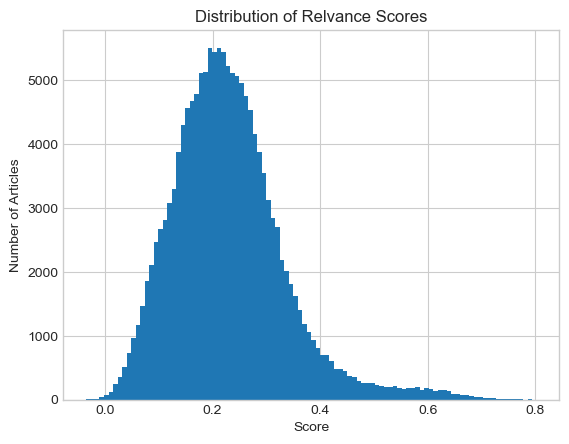

In [ ]:
combined_enriched_df['relevance_score'].hist(bins=100)
plt.title('Distribution of Relvance Scores')
plt.xlabel('Score')
plt.ylabel('Number of Articles')
plt.show()

The distribution of relevance score  reveals that we do not have a LOT of relevant articles. This is to be expected with 150000 articles. This is an arbitrary decision but I will continue this analysis with 0.4 and above ... would be intersting to re-run the notebook with different socres.

## Step 2: Understand food insecurities

For all approaches outline below, the analysis will be similar in the way that we will try to make use of the limited data given in this assignment, meaning we will include the i) risk factor clusters and keywords, ii) the temporal component (unlikely due to super short time horizon) and iii) the spatial component (geographic tags)




In [ ]:
# Country Dissagregation and Cluster Mapping (so we can show english names for arabic cluster...)
# Now lets also explode the data to have rows for each country mentioned in the articles so we can easily dissagregate for countries 

cluster_mapping_arabic_to_english = {
    'أزمة الغذاء': 'food crisis', 'الآفات والأراض': 'pests and diseases', 'التشريد القسري': 'forced displacement',
    'الصراعات والعنف': 'conflicts and violence', 'القضايا الاقتصادية': 'economic issues', 'القضايا البيئية': 'environmental issues',
    'القضايا المتعلقة بالأراضي': 'land-related issues', 'المعونة الإنسانية': 'humanitarian aid', 'عدم الاستقرار السياسي': 'political instability',
    'صدمات الطقس': 'weather shocks', 'قضايا الإنتاج الزراعي': 'agricultural production issues', 'جهات أخرى': 'other'
}
cluster_mapping_english_to_arabic = {v: k for k, v in cluster_mapping_arabic_to_english.items()}

articles_df = pd.read_parquet('new_data/combined_enriched_df.parquet')

# Convert dateTimePub to datetime for visualisation and anylsis.
articles_df['date'] = pd.to_datetime(articles_df['dateTimePub'])
articles_df['all_countries'] = articles_df['all_countries'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else [])
df_exploded = articles_df.explode('all_countries').rename(columns={'all_countries': 'country'})

# First, clean the source column of any leading/trailing whitespace.
df_exploded['assigned_cluster_clean'] = df_exploded['assigned_cluster'].str.strip()

# Initialize the new standardized columns - again we do this mostly for visualisation legend so we understand arabic clusters
df_exploded['cluster_english'] = None
df_exploded['cluster_arabic'] = None

# Identify English and Arabic rows
is_english = df_exploded['lang'] == 'eng'
is_arabic = df_exploded['lang'] == 'ara'

# For English rows: the English name is the original, find the Arabic translation
df_exploded.loc[is_english, 'cluster_english'] = df_exploded.loc[is_english, 'assigned_cluster_clean']
df_exploded.loc[is_english, 'cluster_arabic'] = df_exploded.loc[is_english, 'cluster_english'].map(cluster_mapping_english_to_arabic)

# For Arabic rows: the Arabic name is the original, find the English translation
df_exploded.loc[is_arabic, 'cluster_arabic'] = df_exploded.loc[is_arabic, 'assigned_cluster_clean']
df_exploded.loc[is_arabic, 'cluster_english'] = df_exploded.loc[is_arabic, 'cluster_arabic'].map(cluster_mapping_arabic_to_english)

# Now, drop rows where the standardized English name is still null.
df_exploded_country = df_exploded.dropna(subset=['cluster_english', 'country']).copy()
print("Robust data pre-processing and cluster standardization complete.")
print(df_exploded_country.shape)

Total articles in DataFrame: 150000
Relevant articles (score >= 0.4): 8856

--- Plotting Temporal Analysis ---


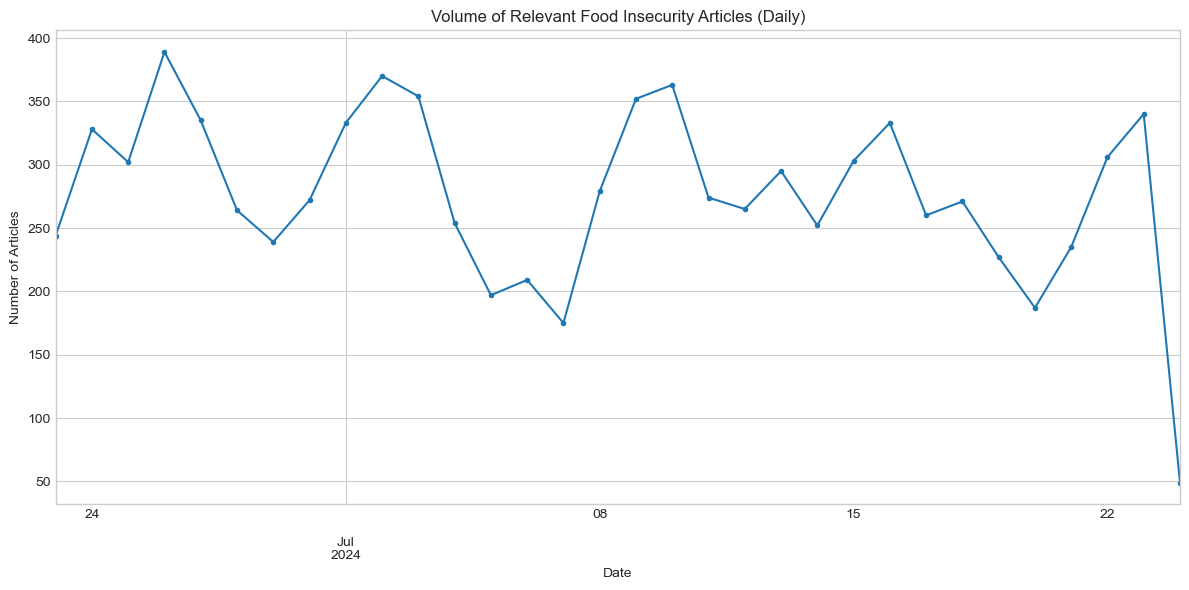


--- Plotting Geospatial Analysis at Country Level ---


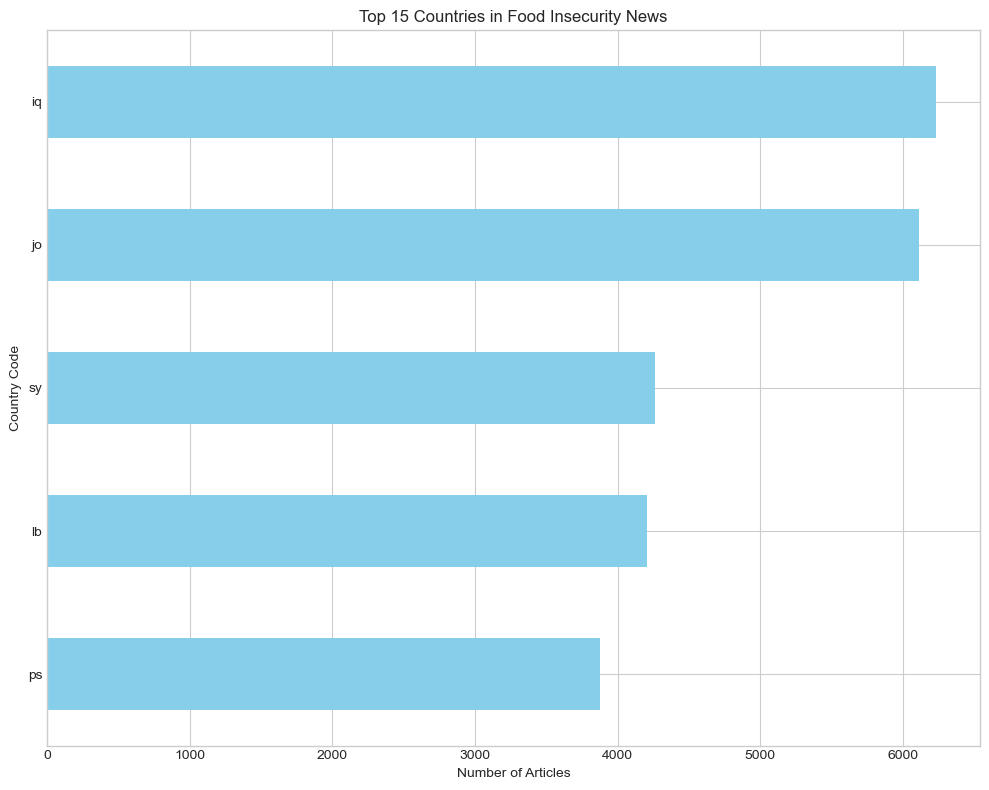


--- Plotting Thematic Analysis ---


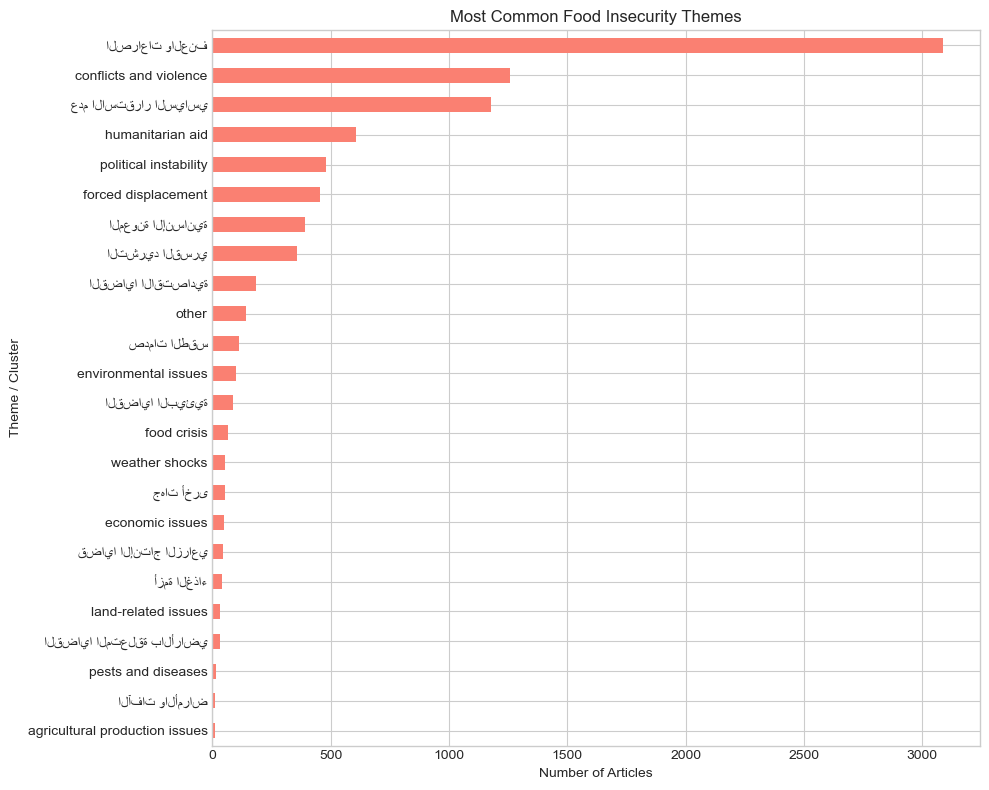

In [12]:
RELEVANCE_THRESHOLD = 0.4
df_relevant = articles_df[articles_df['relevance_score'] >= RELEVANCE_THRESHOLD].copy()

if df_relevant.empty:
    print(f"No articles found with a relevance score of {RELEVANCE_THRESHOLD} or higher.")
else:
    print(f"Total articles in DataFrame: {len(articles_df)}")
    print(f"Relevant articles (score >= {RELEVANCE_THRESHOLD}): {len(df_relevant)}")

    plt.style.use('seaborn-v0_8-whitegrid')
    
    # --- 1. Temporal Analysis ---
    print("\n--- Plotting Temporal Analysis ---")
    df_relevant['date'] = pd.to_datetime(df_relevant['date'], errors='coerce')
    daily_counts = df_relevant.set_index('date').resample('D').size()
    
    if not daily_counts.empty:
        fig, ax = plt.subplots(figsize=(12, 6))
        daily_counts.plot(kind="line", ax=ax, marker='.', linestyle='-', title='Volume of Relevant Food Insecurity Articles (Daily)')
        ax.set_xlabel("Date")
        ax.set_ylabel("Number of Articles")
        plt.tight_layout()
        plt.show()
    else:
        print("Skipping temporal plot because no valid date data was found.")

    # --- 2. Geospatial Analysis (Country Level) ---
    print("\n--- Plotting Geospatial Analysis at Country Level ---")
    locations_column_name = 'all_locations_list'

    def extract_country_codes(locations_str):
        """
        Parses the location string to extract a list of unique country codes.
        """
        if not isinstance(locations_str, str) or not locations_str.startswith('['):
            return []
        try:
            locations_list = ast.literal_eval(locations_str)
            if not isinstance(locations_list, list): return []
            # **FIXED:** Extract the 'country_code' value from each dictionary
            codes = [loc.get('country_code') for loc in locations_list if isinstance(loc, dict) and loc.get('country_code')]
            return list(set(codes))
        except (ValueError, SyntaxError):
            return []

    df_relevant['country_codes'] = df_relevant[locations_column_name].apply(extract_country_codes)
    df_countries = df_relevant.explode('country_codes').dropna(subset=['country_codes'])
    top_countries = df_countries['country_codes'].value_counts().nlargest(15).sort_values()

    if not top_countries.empty:
        fig, ax = plt.subplots(figsize=(10, 8))
        top_countries.plot(kind='barh', ax=ax, color='skyblue')
        ax.set_title('Top 15 Countries in Food Insecurity News')
        ax.set_xlabel("Number of Articles")
        ax.set_ylabel("Country Code")
        plt.tight_layout()
        plt.show()
    else:
        print("--> Skipping geospatial plot: No valid countries were found in the articles meeting the relevance threshold.")

    # --- 3. Thematic Analysis ---
    print("\n--- Plotting Thematic Analysis ---")
    cluster_counts = df_relevant['assigned_cluster'].value_counts().sort_values()

    if not cluster_counts.empty:
        fig, ax = plt.subplots(figsize=(10, 8))
        cluster_counts.plot(kind='barh', ax=ax, color='salmon')
        ax.set_title('Most Common Food Insecurity Themes')
        ax.set_xlabel("Number of Articles")
        ax.set_ylabel("Theme / Cluster")
        plt.tight_layout()
        plt.show()
    else:
        print("Skipping thematic plot because no cluster data was found.")

NOTE: All graphs are on the subset of keeping only > 0.4 relevance score. 9000 observation instead of 150000. More precision definitely but certainly also less recall.

1. The first graph gives a simple overview on how many articles are relevant per day. It would be nice to compare this to "real-world" ground-truth data to see if that matches up!

2. The second graph indicates that most of the relevant things regarind food insecurities are happening in Iraq and Jordan in this month. Note that these country tags are not super reliable without NER - or manually - checking them though. So take everything on country-level that with a grain of salt.

3. The third graph is very intersting and shows us that most clusters are not very prevalent in this month. This I would need to debug for longer time to see if that is just what happened this month, or if my hybrid scoring skews the results. Probaply both a bit.

In [ ]:
df_processed_country = df_exploded_country[df_exploded_country['relevance_score'] >= 0.4].copy()
print("After filtering for more relevant articles, we keep ", len(df_processed_country), "rows.")

After filtering for more relevant articles, we keep  24667 rows.


Daily prevalence has been calculated.


/var/folders/03/70byyv1n5g7d83j8pp_3_phc0000gn/T/ipykernel_86277/4044359257.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_clusters))


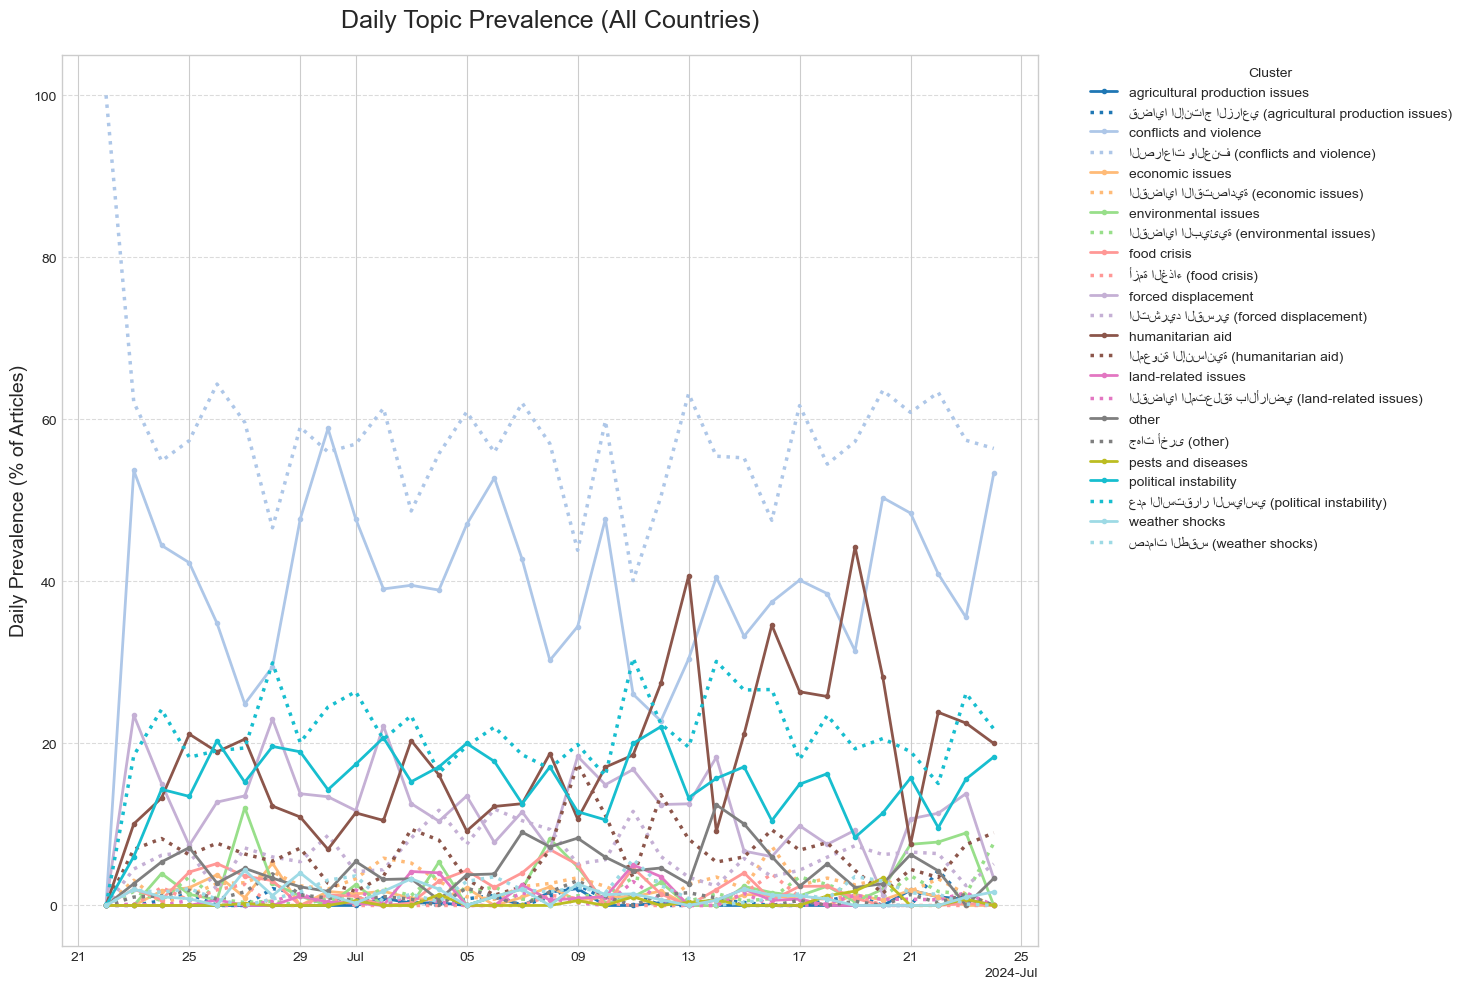

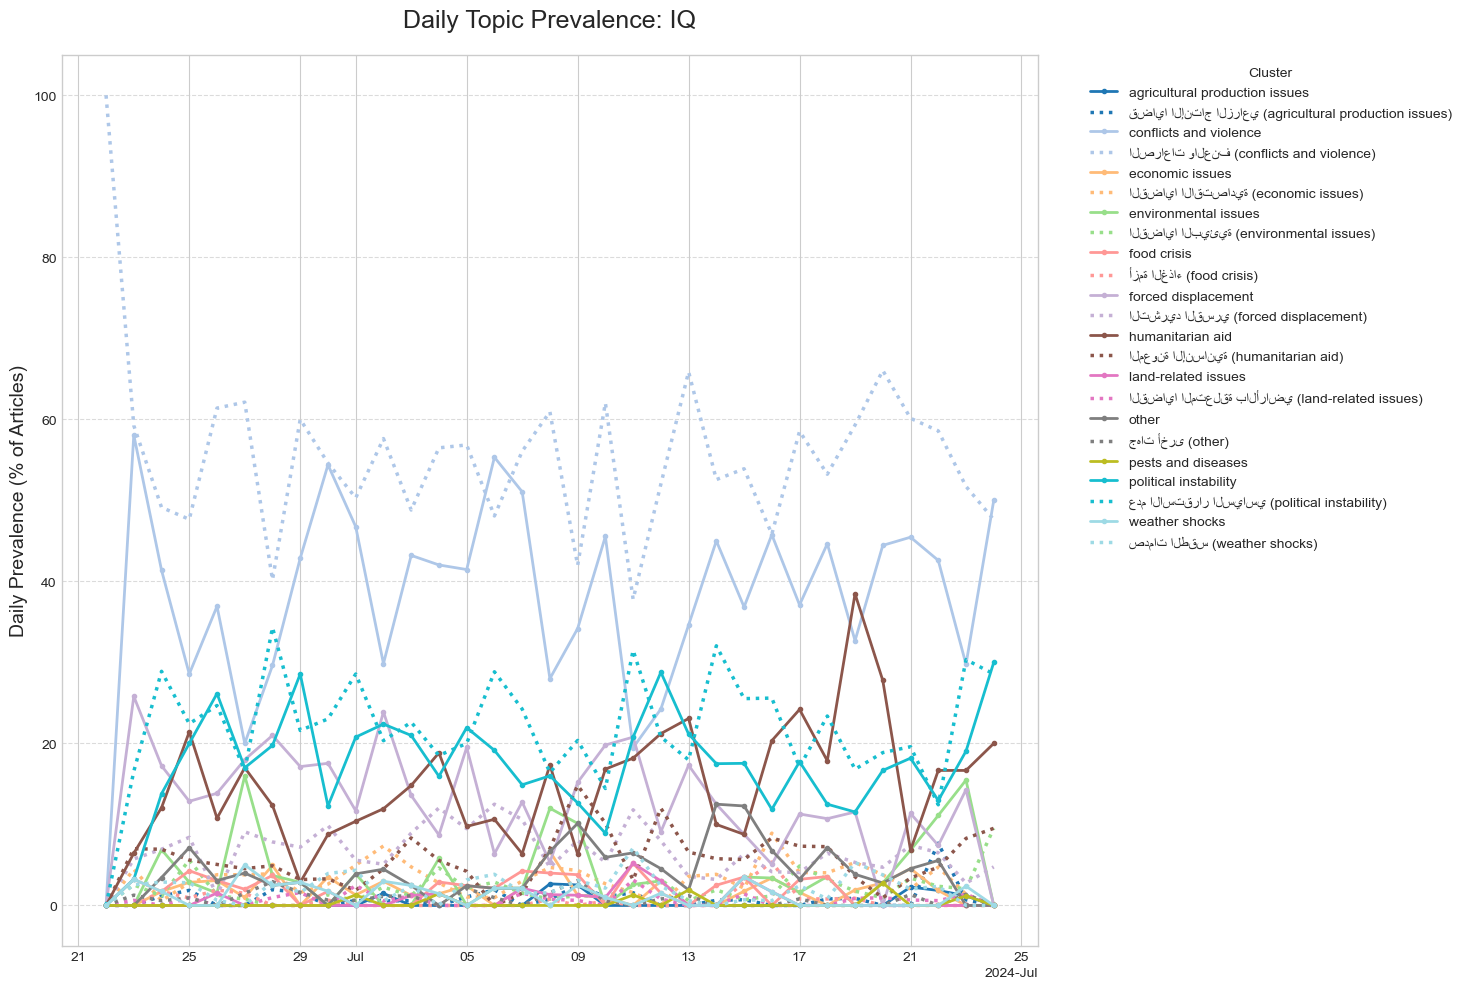

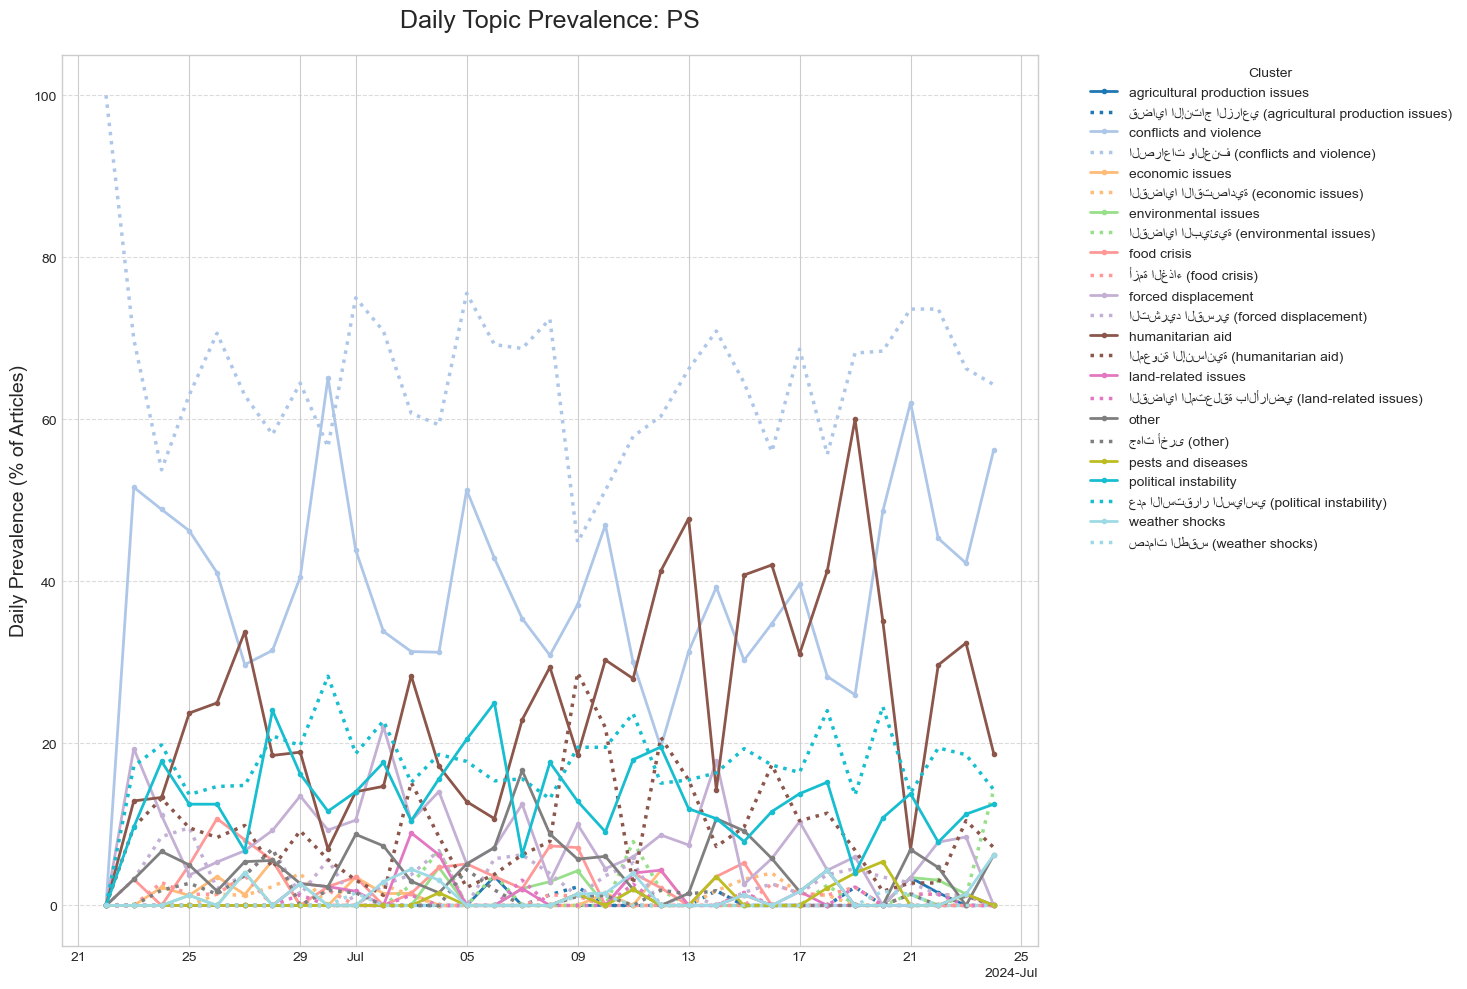

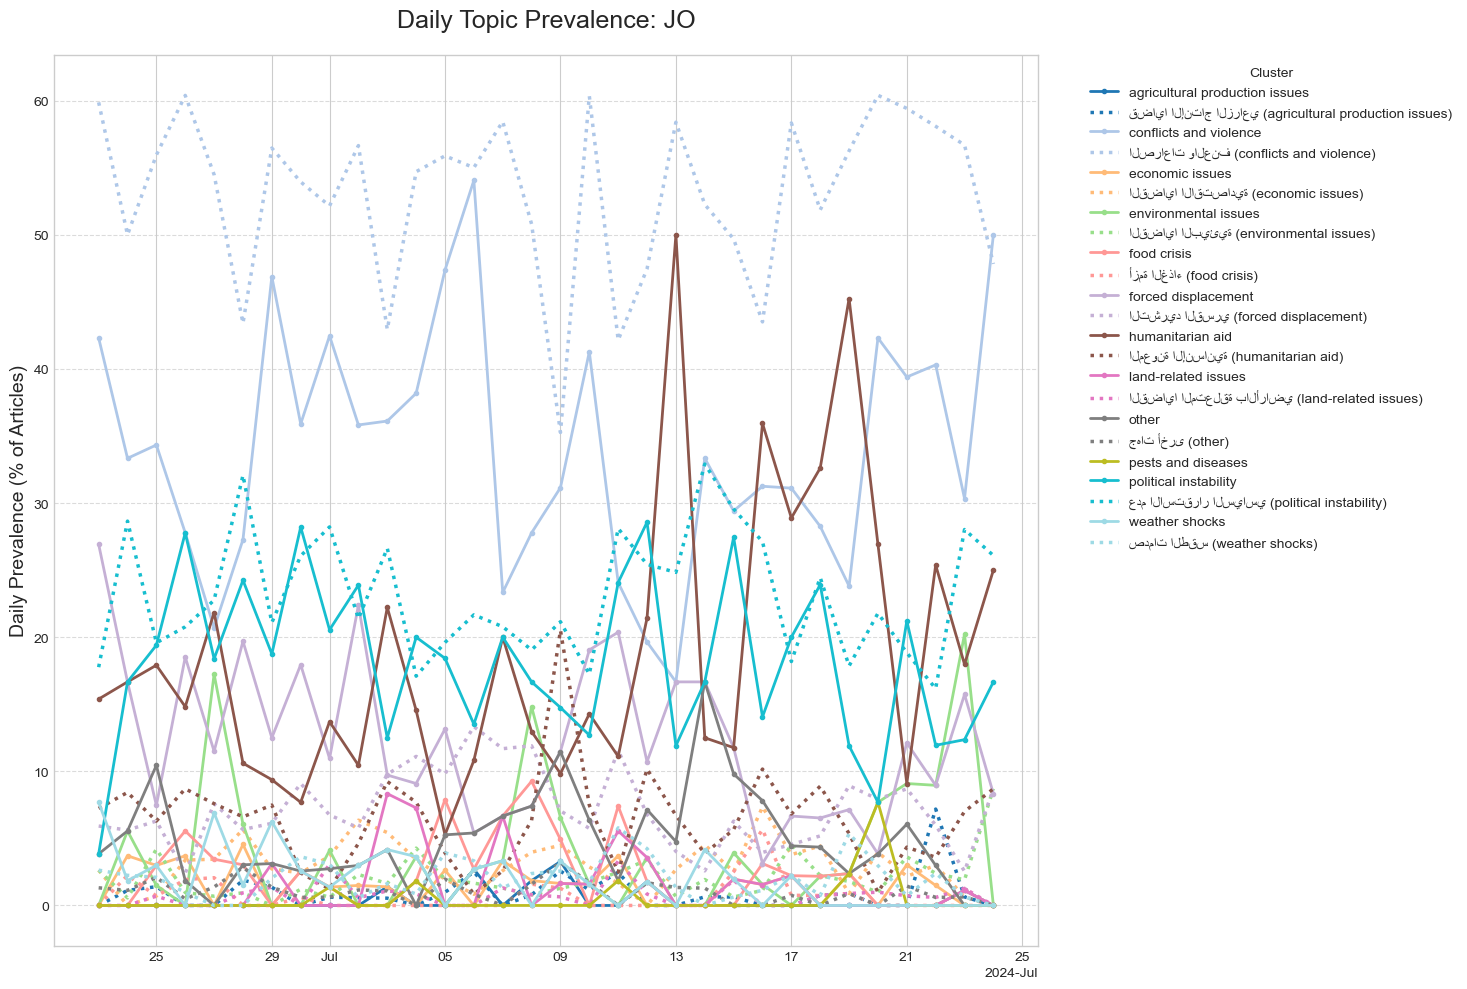

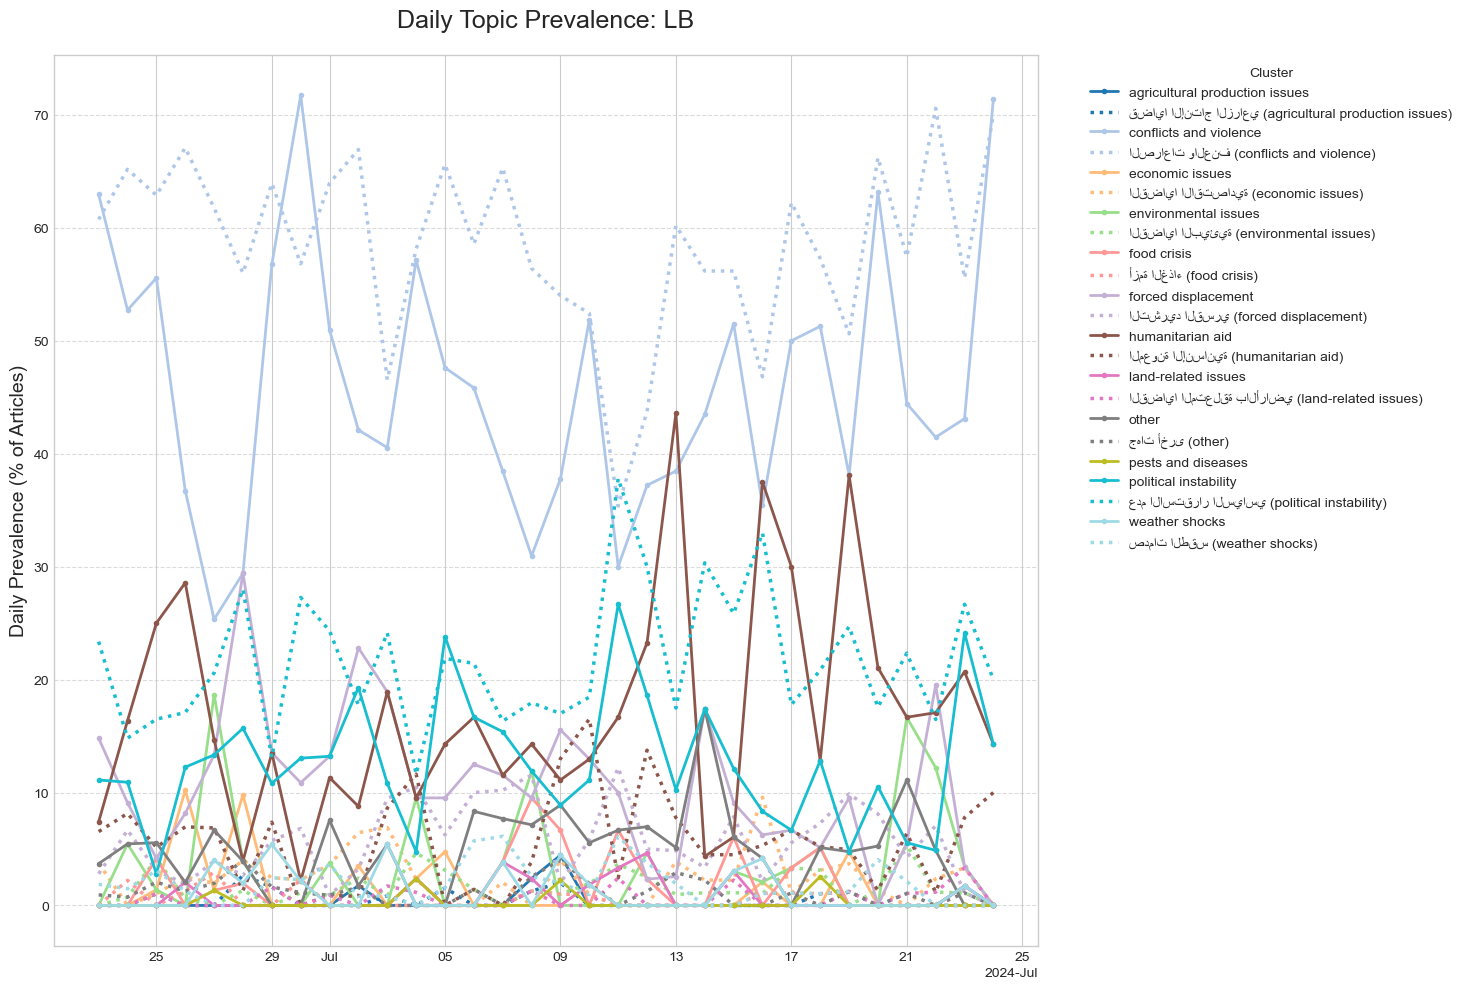

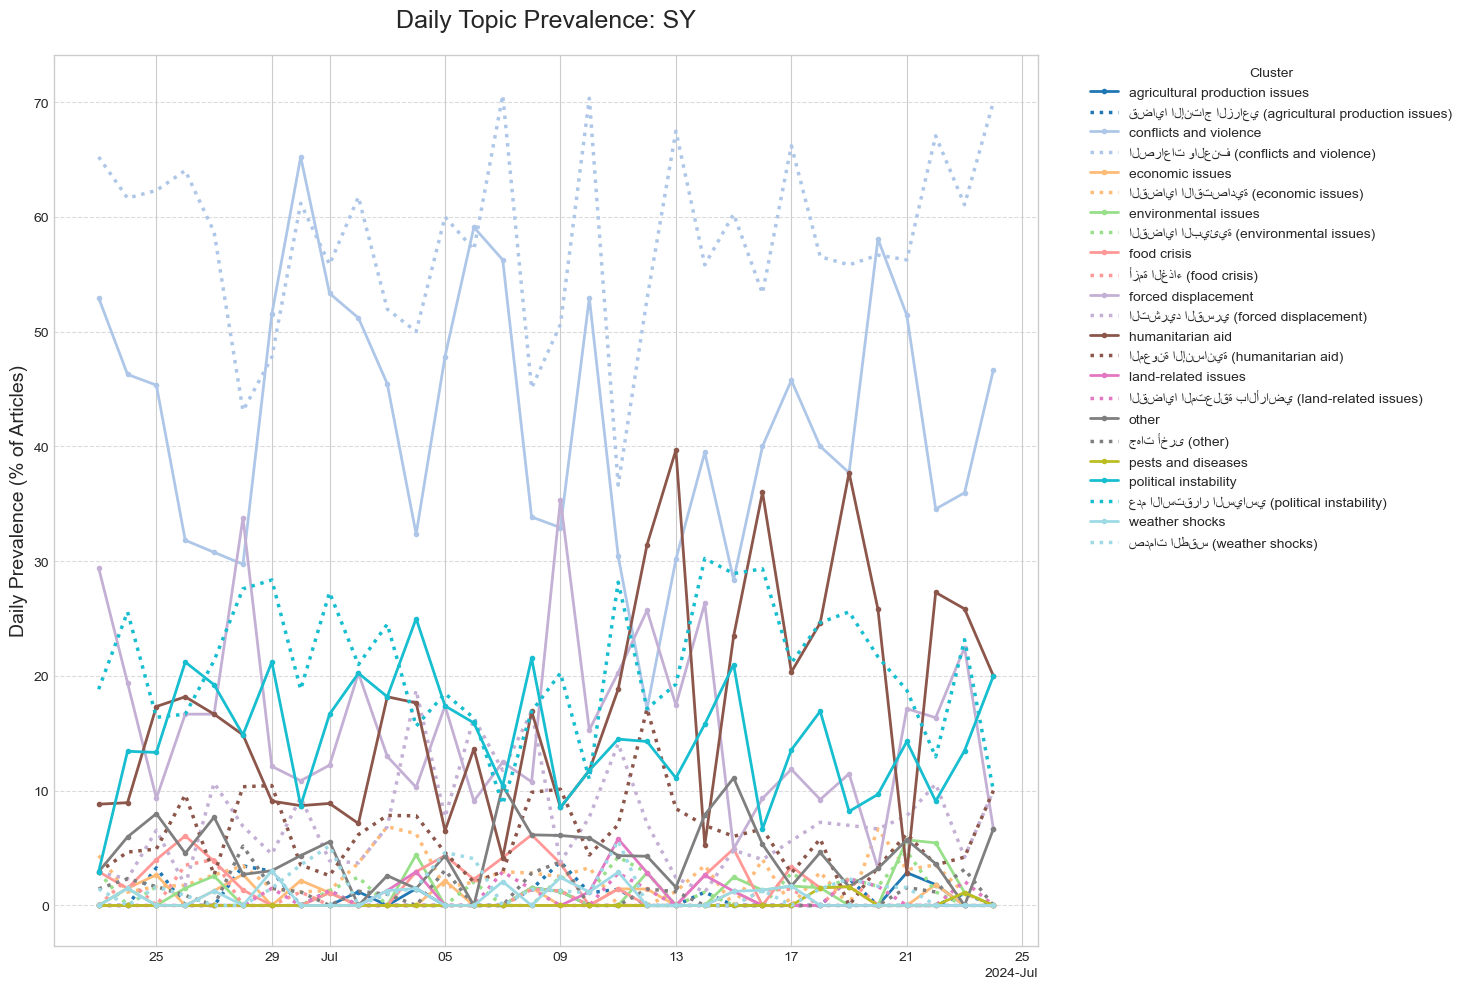

In [31]:
# Group by day, country, and cluster names
daily_counts = df_processed_country.groupby([
    pd.Grouper(key='date', freq='D'), 
    'country', 'cluster_english', 'cluster_arabic', 'lang'
]).size().reset_index(name='article_count')

# Calculate prevalence for each country
total_daily_country = daily_counts.groupby(['date', 'country', 'lang'])['article_count'].transform('sum')
daily_counts['prevalence'] = (daily_counts['article_count'] / total_daily_country) * 100

# Create the "All Countries" aggregation
overall_daily_counts = daily_counts.groupby(['date', 'cluster_english', 'cluster_arabic', 'lang'])['article_count'].sum().reset_index()
total_daily_overall = overall_daily_counts.groupby(['date', 'lang'])['article_count'].transform('sum')
overall_daily_counts['prevalence'] = (overall_daily_counts['article_count'] / total_daily_overall) * 100
print("Daily prevalence has been calculated.")

# --- 4. PIVOT AND PLOT ---

def pivot_data(df):
    pivot = df.pivot_table(index=['date', 'country'] if 'country' in df else ['date'],
                           columns=['cluster_english', 'lang'], values='prevalence').fillna(0)
    pivot.columns = ['_'.join(col).strip() for col in pivot.columns.values]
    return pivot

pivot_country_df = pivot_data(daily_counts)
pivot_overall_df = pivot_data(overall_daily_counts)

unique_clusters = sorted(df_processed_country['cluster_english'].unique())

def create_plot(data, title):
    fig, ax = plt.subplots(figsize=(18, 10))
    colors = plt.cm.get_cmap('tab20', len(unique_clusters))
    ax.set_title(title, fontsize=18, pad=20)

    for i, cluster_name_eng in enumerate(unique_clusters):
        col_eng = f"{cluster_name_eng}_eng"
        col_ara = f"{cluster_name_eng}_ara"
        cluster_name_ara = cluster_mapping_english_to_arabic.get(cluster_name_eng, "")
        color = colors(i)

        if col_eng in data.columns and data[col_eng].sum() > 0:
            ax.plot(data.index, data[col_eng], color=color, linestyle='-', linewidth=2, marker='o', markersize=3, label=cluster_name_eng)
        if col_ara in data.columns and data[col_ara].sum() > 0:
            ax.plot(data.index, data[col_ara], color=color, linestyle=':', linewidth=2.5, label=f"{cluster_name_ara} ({cluster_name_eng})")

    ax.set_ylabel('Daily Prevalence (% of Articles)', fontsize=14) # <-- **UPDATED**
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    locator = mdates.AutoDateLocator(minticks=10, maxticks=15)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    
    ax.legend(title='Cluster', bbox_to_anchor=(1.04, 1), loc='upper left', fontsize=10)
    plt.tight_layout(rect=[0, 0, 0.83, 1])
    plt.show()


create_plot(pivot_overall_df, 'Daily Topic Prevalence (All Countries)')

countries = pivot_country_df.index.get_level_values('country').unique()
for country in countries:
    country_data = pivot_country_df[pivot_country_df.index.get_level_values('country') == country]
    country_data = country_data.reset_index(level='country', drop=True)
    create_plot(country_data, f'Daily Topic Prevalence: {country.upper()}')


The figures are arguably a bit difficult to interpret - also for this short time span of one month data, time series data is not very much useful, but we can carefully "suggest" a few observations:

- Arabic news are always more prevalent in terms of Conflicts and Violents in each country and also overall. 
- English news likewise are throughoutly more prevalent for Humanitarian Aid. 
- We could carefully try to observe some lagged response such as - after a spike in news on armed conflicts we can observe a spike in news on forced displacement or humanitarian aid. But Daily observations for one month seem to messy to conclude anything here. 
- I tried to also run a numerical correlation analysis but deleted it as the lag was too small I think


working with  8856 rows.

 Exploded to  29424 rows on district level


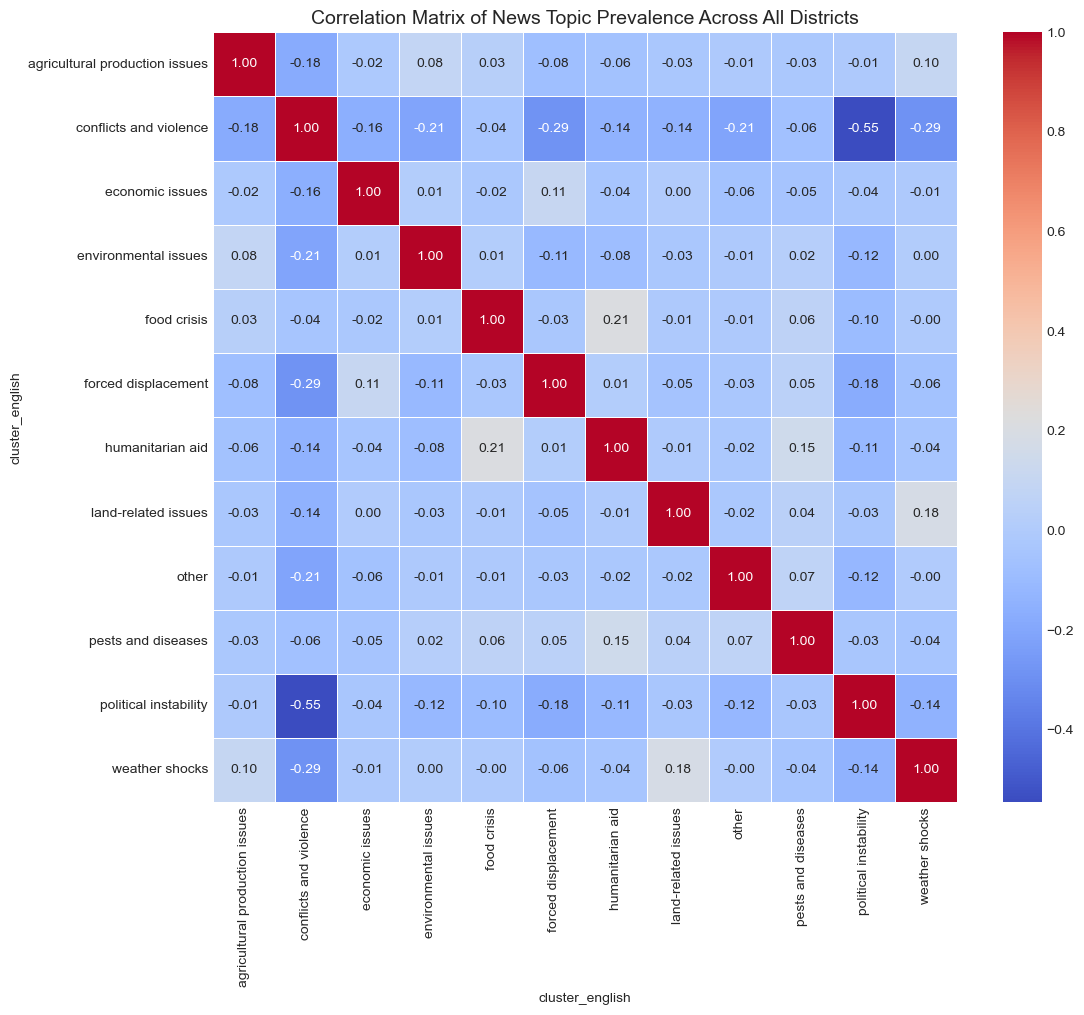


Identifying Geographic Hotspots

--- Top 5 Hotspots for 'food crisis' ---
district_code
iq_ba_6     18.750000
sy_su_3     14.285714
iq_an_7     11.764706
ps_wb_10    11.111111
ps_gz_3     10.000000
Name: food crisis, dtype: float64

--- Top 5 Hotspots for 'conflicts and violence' ---
district_code
lb_na_2    100.0
lb_na_3    100.0
iq_bg_7    100.0
sy_hl_5    100.0
iq_ma_6    100.0
Name: conflicts and violence, dtype: float64


In [32]:
articles_df = pd.read_parquet('new_data/combined_enriched_df.parquet')
df_processed_districts = articles_df[articles_df['relevance_score'] >= 0.4].copy()
print("working with ", len(df_processed_districts), "rows.")

df_processed_districts['all_districts'] = df_processed_districts['all_districts'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x if isinstance(x, list) else [])
df_districts = df_processed_districts.explode('all_districts').rename(columns={'all_districts': 'district_code'})
print("\n Exploded to ", len(df_districts), "rows on district level")
# Standardize the cluster names
df_districts['cluster_english'] = df_districts['assigned_cluster']
is_arabic = df_districts['lang'] == 'ara'
df_districts.loc[is_arabic, 'cluster_english'] = df_districts.loc[is_arabic, 'assigned_cluster'].map(cluster_mapping_arabic_to_english)
df_districts.dropna(subset=['cluster_english', 'district_code'], inplace=True)

# Aggregate news prevalence across ALL districts
total_articles_per_district = df_districts.groupby('district_code')['uri'].count()
cluster_counts_per_district = df_districts.groupby(['district_code', 'cluster_english'])['uri'].count()
all_districts_prevalence = (cluster_counts_per_district / total_articles_per_district * 100).unstack(fill_value=0)


# Calculate the correlation matrix for all clusters
correlation_matrix = all_districts_prevalence.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5
)
plt.title('Correlation Matrix of News Topic Prevalence Across All Districts', fontsize=14)
plt.show()


# Analysis 2: Hotspot Identification
print("\nIdentifying Geographic Hotspots")
def find_hotspots(cluster_name, prevalence_df, top_n=5):
    """
    The code selects a single column from all_districts_prevalence DataFrame (e.g., 'economic issues'), 
    sorts all the districts (the rows) by their prevalence value in that  column from highest to lowest, 
    and displays the top 5.
    """
    if cluster_name not in prevalence_df.columns:
        print(f"Error: Cluster '{cluster_name}' not found.")
        return
    
    hotspots = prevalence_df[cluster_name].sort_values(ascending=False).head(top_n)
    
    print(f"\n--- Top {top_n} Hotspots for '{cluster_name}' ---")
    print(hotspots)

# Example1: Find the districts with the most prevalent news on "economic issues"
find_hotspots('food crisis', all_districts_prevalence)

# Example2: Find hotspots for "conflicts and violence"
find_hotspots('conflicts and violence', all_districts_prevalence)


The heatmap aims to tackle the question, "When news about Topic A is prevalent in a district, what other topics are likely to be prevalent there too?" In this current month/time period that our data spans.

For example, we see a value of -0.57 between 'conflicts and violence' and 'humanitarian aid'. It suggests that districts with a high prevalence of conflict news tend to have a low prevalence of humanitarian aid news. This might be because the news narrative in a given district focuses on either the fighting or the aid response. 

We have not much positive correlation but I think here we suffer the non existent time variable of this analysis. The news most likely appear after each and there we find a correlation.


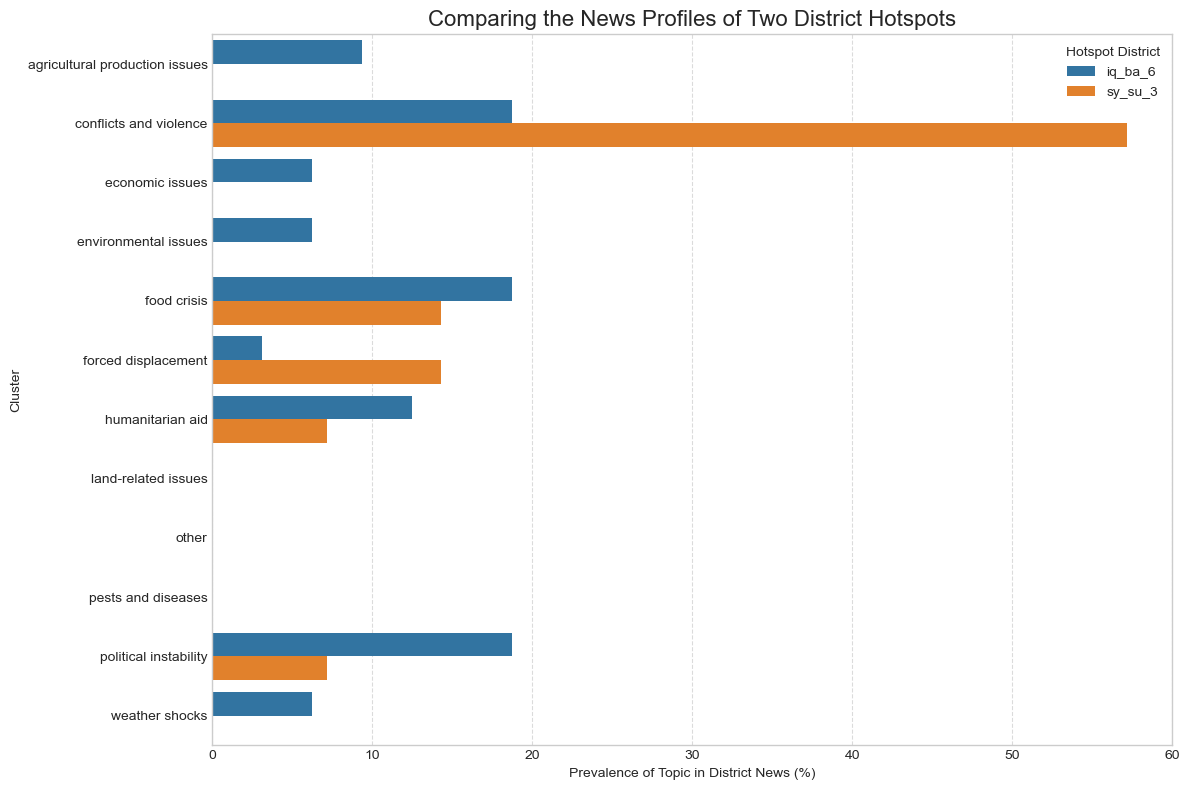

In [52]:
# Select a top hotspot from each of the previously identified categories

def compare_districts(hotspotcode_1, hotspotcode_2):
    # Get the full data rows for these two districts
    hotspot_profiles = all_districts_prevalence.loc[[hotspotcode_1, hotspotcode_2]].copy()

    # Prepare the data for plotting by melting the DataFrame
    hotspot_profiles.reset_index(inplace=True)
    plot_data = hotspot_profiles.melt(id_vars='district_code', var_name='cluster', value_name='prevalence')

    # Create the comparison bar chart
    plt.figure(figsize=(12, 8))
    sns.barplot(data=plot_data, x='prevalence', y='cluster', hue='district_code', orient='h')

    plt.title('Comparing the News Profiles of Two District Hotspots', fontsize=16)
    plt.xlabel('Prevalence of Topic in District News (%)')
    plt.ylabel('Cluster')
    plt.legend(title='Hotspot District')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

compare_districts("iq_ba_6", 'sy_su_3' )

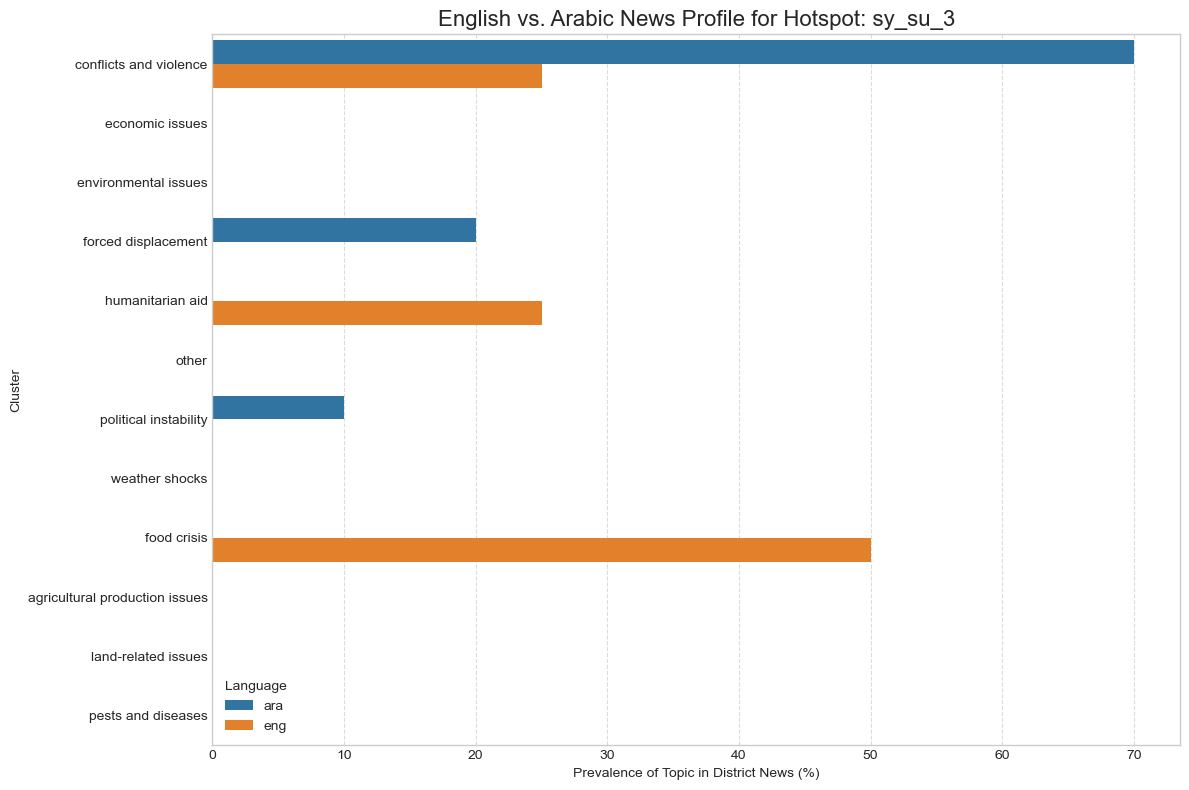

In [57]:
# Calculate total articles per district AND per language
total_articles_per_district_lang = df_districts.groupby(['district_code', 'lang'])['uri'].count()

# Calculate cluster counts per district AND per language
cluster_counts_per_district_lang = df_districts.groupby(['district_code', 'lang', 'cluster_english'])['uri'].count()

# Calculate prevalence and unstack to get 'eng' and 'ara' columns for each cluster
district_prevalence_by_lang = (cluster_counts_per_district_lang / total_articles_per_district_lang * 100).unstack(level=['lang', 'cluster_english'], fill_value=0)


# Check if the district exists in the data
def hotspot_language_comparison(hotspot_code_to_analyze):
    hotspot_data = district_prevalence_by_lang.loc[hotspot_code_to_analyze].copy()
    
    # Restructure the data for plotting
    hotspot_data.index.names = ['lang', 'cluster'] 
    plot_data = hotspot_data.reset_index()
    plot_data.rename(columns={hotspot_data.name: 'prevalence'}, inplace=True)

    # Create the grouped bar chart
    plt.figure(figsize=(12, 8))
    sns.barplot(data=plot_data, x='prevalence', y='cluster', hue='lang', orient='h')
    
    plt.title(f'English vs. Arabic News Profile for Hotspot: {hotspot_code_to_analyze}', fontsize=16)
    plt.xlabel('Prevalence of Topic in District News (%)')
    plt.ylabel('Cluster')
    plt.legend(title='Language')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

hotspot_language_comparison('sy_su_3' )

The single comparisons are helpful to understand what is actually happening in one of the identified hotspot districts. 
- The first function allows us to compare to districts with each other and see what is mostly reported on (remember we are still looking at the subste <0.4 relevance articles).
- The second function allows us to compare english and arabic news coverage by cluster prevelance for a given district. We see for example that while English media reports on humanitarian aid in the As-Suwayda Governorate in Syria, arabic news focus more on conflicts and violence.

### Leveraging Bilingual and Sentiment Information

Unfortunately, we only have english sentiment scores. Lets see if we can classify the arabic articles with some open source sentiment model in reasonable time and then do a comparison.

In [ ]:
# copying df again so we can set the threshold as we want for this task without changing anything above
filtered_df = combined_enriched_df[combined_enriched_df['relevance_score'] >= 0.4].copy()

In [ ]:
# Load the PRAli22 Arabic sentiment analysis model
model_name = "PRAli22/AraBert-Arabic-Sentiment-Analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Check distribution by language
for lang in ['english', 'arabic']:
    count = len(filtered_df[filtered_df['language'] == lang])
    print(f"  {lang.capitalize()}: {count} articles")

def predict_arabic_sentiment_fixed(text, max_length=1000):
    """
    Predict sentiment for Arabic text using PRAli22 model (4 classes)
    Returns sentiment score between 0 and 1 (continuous)
    """
    if pd.isna(text) or text == '':
        return 0.5
    if len(text) > max_length:
        text = text[:max_length]
    
    try:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=max_length)
        with torch.no_grad():
            outputs = model(**inputs)
            predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        
        probs = predictions[0].numpy()
        
        # FIXED CONVERSION for 4-class model:
        # Class 0 = Positive, Class 1 = Negative, Class 2&3 = Neutral
        # Use Class 0 probability as positive sentiment
        sentiment_score = float(probs[0])
        
        return sentiment_score
        
    except Exception as e:
        print(f"Error processing text: {e}")
        return 0.5


# Apply sentiment prediction to Arabic articles
print(f"\n=== APPLYING SENTIMENT PREDICTION TO ARABIC ARTICLES ===")
arabic_articles = filtered_df[filtered_df['language'] == 'arabic'].copy()
print(f"Processing {len(arabic_articles)} Arabic articles...")

# Process Arabic articles in batches
batch_size = 20
arabic_sentiments_fixed = []

for i in range(0, len(arabic_articles), batch_size):
    batch = arabic_articles.iloc[i:i+batch_size]
    print(f"Processing batch {i//batch_size + 1}/{(len(arabic_articles)-1)//batch_size + 1}")
    
    for _, row in batch.iterrows():
        full_text = f"{row.get('title', '')} {row.get('body', '')}"
        sentiment = predict_arabic_sentiment_fixed(full_text)
        arabic_sentiments_fixed.append(sentiment)

# Update the filtered dataframe with corrected sentiments
filtered_df.loc[filtered_df['language'] == 'arabic', 'sentiment'] = arabic_sentiments_fixed

=== TESTING FIXED CONVERSION ===
'الحرب سيئة جداً' → 0.025
'الناس يموتون' → 0.051
'هذا مأساة' → 0.025
'السلام جميل' → 0.838
'الناس سعداء' → 0.763

=== RE-RUNNING SENTIMENT PREDICTION WITH FIXED CONVERSION ===
Processing batch 1/280
Processing batch 2/280
Processing batch 3/280
Processing batch 4/280
Processing batch 5/280
Processing batch 6/280
Processing batch 7/280
Processing batch 8/280
Processing batch 9/280
Processing batch 10/280
Processing batch 11/280
Processing batch 12/280
Processing batch 13/280
Processing batch 14/280
Processing batch 15/280
Processing batch 16/280
Processing batch 17/280
Processing batch 18/280
Processing batch 19/280
Processing batch 20/280
Processing batch 21/280
Processing batch 22/280
Processing batch 23/280
Processing batch 24/280
Processing batch 25/280
Processing batch 26/280
Processing batch 27/280
Processing batch 28/280
Processing batch 29/280
Processing batch 30/280
Processing batch 31/280
Processing batch 32/280
Processing batch 33/280
Processi

Mapping results:
  English: 3269/3269 articles have english_cluster
  Arabic: 5587/5587 articles have english_cluster


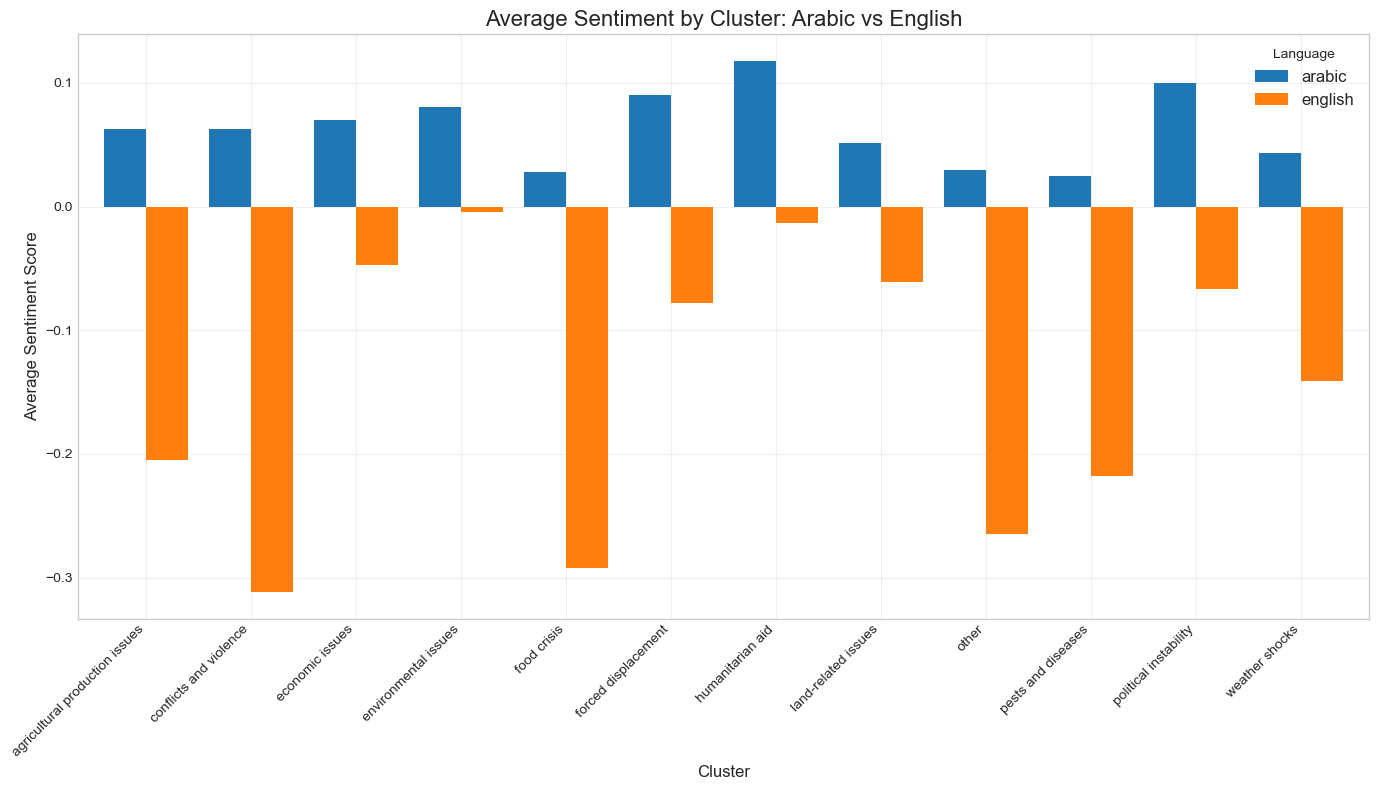

In [ ]:

# For English articles, use the assigned_cluster as english_cluster
filtered_df.loc[filtered_df['language'] == 'english', 'english_cluster'] = filtered_df[filtered_df['language'] == 'english']['assigned_cluster']

# For Arabic articles, map from Arabic to English
filtered_df.loc[filtered_df['language'] == 'arabic', 'english_cluster'] = filtered_df[filtered_df['language'] == 'arabic']['assigned_cluster'].map(cluster_mapping)

# Check the mapping results
print("Mapping results:")
for lang in ['english', 'arabic']:
    lang_df = filtered_df[filtered_df['language'] == lang]
    mapped = lang_df['english_cluster'].notna().sum()
    total = len(lang_df)
    print(f"  {lang.capitalize()}: {mapped}/{total} articles have english_cluster")

# Group by English cluster names and language
unified_sentiment = filtered_df.groupby(['english_cluster', 'language'])['sentiment'].agg(['mean', 'std', 'count']).round(3)

# Pivot to compare Arabic vs English side by side
sentiment_pivot = filtered_df.pivot_table(
    values='sentiment',
    index='english_cluster',
    columns='language',
    aggfunc=['mean', 'std', 'count']
).round(3)

# Flatten column names
sentiment_pivot.columns = [f"{col[1]}_{col[0]}" for col in sentiment_pivot.columns]

# Create visualization with both languages for each cluster
plt.figure(figsize=(14, 8))

# Prepare data for plotting
plot_data = filtered_df.groupby(['english_cluster', 'language'])['sentiment'].mean().reset_index()

# Create a pivot table for plotting
plot_pivot = plot_data.pivot(index='english_cluster', columns='language', values='sentiment')

# Plot comparison
plot_pivot.plot(kind='bar', ax=plt.gca(), width=0.8)
plt.title('Average Sentiment by Cluster: Arabic vs English', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Average Sentiment Score', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Language', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Ok we see that our calculated sentiments go from 0 to 1 while the english sentiments go from -1 to 1 it seems. Lets unify and use one multilingual sentiment classifier to re-classify and also make it more comparable among each other.

Loading tabularisai/multilingual-sentiment-analysis model...
Model loaded successfully!

=== TESTING MODEL OUTPUTS ===

Text: 'I love this product! It's amazing and works perfectly.'
Probabilities: [0.0153834  0.01968413 0.03324102 0.37306088 0.5586306 ]
Predicted class: 4
Max probability: 0.559

Text: 'This service was terrible and disappointing.'
Probabilities: [0.661002   0.2797472  0.01686106 0.01958645 0.02280341]
Predicted class: 0
Max probability: 0.661

Text: 'The weather is fine, nothing special.'
Probabilities: [0.02946456 0.06292547 0.6865231  0.19558747 0.02549946]
Predicted class: 2
Max probability: 0.687

=== TESTING SIMPLE FUNCTION ===
'I love this product! It's amazing and works perfectly.' → 0.779
'This service was terrible and disappointing.' → 0.169
'The weather is fine, nothing special.' → 0.500

=== CREATING FILTERED DATAFRAME ===
Filtered dataframe: 8856 articles (relevance >= 0.4)

=== APPLYING SENTIMENT PREDICTION ===
Processing batch 1/443
Processing batch 2/44

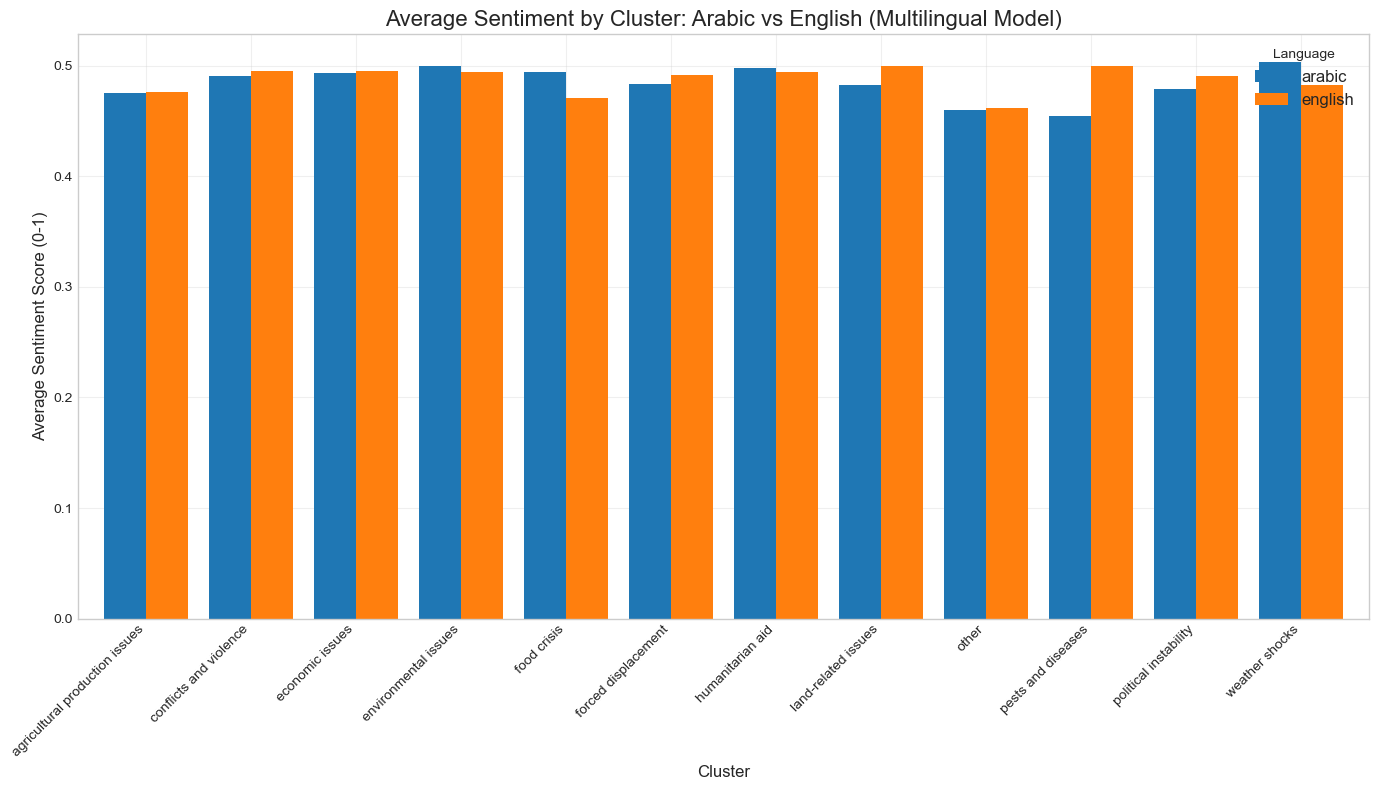

In [ ]:
# Load the multilingual sentiment analysis model
print("Loading tabularisai/multilingual-sentiment-analysis model...")
model_name = "tabularisai/multilingual-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
print("Model loaded successfully!")


# Create a simple, robust sentiment function
def predict_sentiment_simple(text, max_length=512):
    """
    Simple sentiment prediction using the highest probability class
    Returns sentiment score between 0 and 1
    """
    if pd.isna(text) or text == '':
        return 0.5
    if len(text) > max_length:
        text = text[:max_length]
    
    try:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=max_length)
        with torch.no_grad():
            outputs = model(**inputs)
            predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        
        probs = predictions[0].numpy()
        predicted_class = np.argmax(probs)
        confidence = probs[predicted_class]
        
        # Map classes to scores: 0=Very Negative, 1=Negative, 2=Neutral, 3=Positive, 4=Very Positive
        class_scores = [0.0, 0.25, 0.5, 0.75, 1.0]
        base_score = class_scores[predicted_class]
        
        # Use confidence to adjust the score
        # If confidence is high, use the class score directly
        # If confidence is low, move toward neutral (0.5)
        sentiment_score = base_score * confidence + 0.5 * (1 - confidence)
        
        return float(sentiment_score)
        
    except Exception as e:
        print(f"Error processing text: {e}")
        return 0.5


# Create filtered dataframe
print(f"\n=== CREATING FILTERED DATAFRAME ===")
filtered_df = combined_enriched_df[combined_enriched_df['relevance_score'] >= 0.4].copy()
print(f"Filtered dataframe: {len(filtered_df)} articles (relevance >= 0.4)")

# Apply sentiment prediction to both languages
print(f"\n=== APPLYING SENTIMENT PREDICTION ===")

# Process all articles in batches
batch_size = 20
all_sentiments = []

for i in range(0, len(filtered_df), batch_size):
    batch = filtered_df.iloc[i:i+batch_size]
    print(f"Processing batch {i//batch_size + 1}/{(len(filtered_df)-1)//batch_size + 1}")
    
    for _, row in batch.iterrows():
        full_text = f"{row.get('title', '')} {row.get('body', '')}"
        sentiment = predict_sentiment_simple(full_text)
        all_sentiments.append(sentiment)

# Update the dataframe
filtered_df['multilingual_sentiment'] = all_sentiments

Sentiment Analysis does not reveal a big difference for now. I assume it stems from the max token parameter (not processing the full texts) as well as from the model performance. 

Would need to be continued with more time.

## External Data Approach

## Step 3: Prediction - Allow a new/unseen article to be placed in the risk pipeline

### No time for this but would be my next step to get some external validation data or at least some timestamps for food insecurity events

# Part 2: Reflection

Please outline (1) some of the limitations of your approach and (2) how you would tackle these if you had more time.

## 1) Overall Approach

### Data
- My first task was to leverage all given data and create one main dataframe using:
    - the geographical information, exploded by country and district.
    - the cluster and keyword information.
    - the news afticle dataframe itself.

- Many news article are not relevant. This became quickly clear. So I had to find a way to reduce the dataset to more relecant articles to have confidence in my analysys.

1. The Geographical information ***--> Geospatial_exploration.ipynb***
    -  Geographical data was the most challenging one. As it is merely location names that are sometimes pretty cryptic and just words such as "air" or "ancient" etc. Thus we have always a match and it does not reduce the dataset at all to filter for matches here. 
    - Many articles are ambigious in ther location naming: "Jordan" for example is often a Name or referred to basketball etc. This is the case for many other of our location names.
    --> The gold standard solution here is implemented in the geospatial_exploration notebook and would be to use some multilingual neural NER model to check each location match as a NER or not. I implemented it but the scripts takes forever to run on my CPU for the full dataset (1h for 100 observations)...
    - We moved along with fuzzy + keyword tagging.

2. Cluster and Keyword Information ***--> keyword_exploration.ipynb***
    - First thing is that I checked whether both excel list contain different information and validated that this is NOT the case and difference was a simple typo/inconsistency. I continued to work with the risk-factors-categories.xlsx
    - I noticed we only have english keywords - so I used an open-source translation API to translate also into arabic to have a full dataset. Saved under new_data/bilingual_clusters.xlsx 
    ***--> translation_of_keywords.ipynb***

3. The news article dataframe + Tagging ***--> news_article_exploration.ipynb***
    - Not much to clean up here. It looked pretty complete. I simply removed some special characters etc in the text and checked if the duplicate and other columns are helpful. But looked pretty good. 

### Data Limitation & Considerations

- Using a simple lookup - even with fuzzy matching - The Geographic information is difficult to trust without NER check.
- The timeframe is super small (31 days) so timeseries analysis makes not much sense as we do not have any baseline or time to estimate or extract trends. Time series prediction will not make sense for such a geopolitical topic within 31 days. I thought about doing this with external ground truth data a lot but concluded it makes not much sense.
- Many columns of the articles dataframe remain unused and would be interesting to further inspect, for example sourcece credibility - considering if certain news sources (e.g., humanitarian news agencies) are more reliable indicators than others. 
- The sentiment column was only given for english news so I estimated it again for english + arabic with a multilingual open-source SA model. The results are not too great thoug and this would need further tweaking. 


## 2) Limitations of My Approach
This seems like a very complex research topic and I could have spend probably months working on this. So each step has a lot of limitations:

- After deciding I will not go for any time series analysis due to the short time frame, I wanted to find a way to assing each cluster to one of the articles. This is more or less a (zero-shot)classification system. I first only did keyword matching which was not reliable, then semantic similarity but some of the embedding vectors are so short that I did not want to trust it as well. Eventually I developed some sort of hybrid approach. ***LIMITATIONS***:
    - My parameters (score weights, keyword density, etc) are picked by playing around - not empirical. 
    - Embedding Vectors are super small.
    - multilingual sentence transformer model prob far away from SOTA english models. 
    - I only worked with 75000 rows for each language as the transformer models took some time to run.

- Result is dataframe where each cluster has a similarty score assigned and an overall relevance score is calculated with the hybrid approach. I then filtered the 150000 datapoints to approx 8000 by only keeping rows with relevance >0.4. I thought it is really important to remove the not relevant articles somehow. With geographic tagging (without NER) it was not possible.  ***LIMITATIONS***:
    - This thresshold is arbitrary and not empirical again. Precision is hopefully good but Recall probably not. 
    - No testing how many relevant articles we loose. 
    -  My next step in the analysis is looking at the cluster distributions and I see that some clusters are much more prominent than others. I assume these are the ones with longer keyword lists since they will have a higher relevance score in my methodoloy. This skews the analysis.

- I then decidided to move towards a spatial analysis on DISTRICT level. As districts seemed the most reliable geographic name tags for me.  ***LIMITATIONS***:
    - this is a one-month snapshot. I think news-wise this is not enough to do a proper spatial anlysis.
    - The Heatmap allows us to see whether clusters co-occur in a district within this month. There is some positive correlation but not much and more negative. I think that makes sense as big news item take the floor and do not leave much room for others. 
    - I assume correlation is not spatial but temporal - and the heatmap does not cover this component.  I would love to check that with a larger timeframe dataset. 
    - Comparing two hotspot districts is cool to see what news clusters are prevalent. It would have been great though to have a larger-spatial comparison - or include more districts.
    - Language News comparion is also cool but same: Over more districts it would have been better to see patterns. Time was the limiting factor here.

- The sentiment analysis could have been really interesting to see if different news languages have different sentiments abou topics. For example, we could use this (again in a larger time horizon) to see if a changing sentiment can indicate certaing food insecurities.  ***LIMITATIONS***:
    - limitations are mostly technical as the multilingual sentiment classification model I used seems to not give the most reliable results. Max token could be a problem and also the way I normalised the score (to get something clean between 0 and 1) instead of using the 4 pre-defined categories of this model. Again, time was the most limiting factor here.


## 3) Room for Improvement:

1. Biggest one - remove articles that are simply not relevant. Like articles talking about Jordan in a basektball context. I think doing some NER or semantic parsing would be great but time did not really allow for that. Hence, my approach with this hybrid relavance score
2. Georeferences for the locations to map would have been great as well with open street map or something similar.
3. Definitely adding more external data, like validated events of food insecurity, famines etc. That would allow for prediction.
4. Have a larger time horizon to properly include the time component in the analysis. Temporal analysis was a bit difficult with only 31 days of messy data. 
5. Using better models for similarty scores or sentinment analysis. 
6. Empirically estimating good parameters and doing it with simply testing and looking at the results myself. 
7. Make use of more of the column information - sentiment, Source Diversity (Check western media bias, providing more local perspectives, etc).
8. Make more use of bilingual data: 
    - Regional Coverage: Arabic sources may report local events before international media
    - Cultural Context: Different terminology and framing for food security issues. Maybe we can learn something here?
    - Temporal Advantage: Local media may report events days/weeks earlier
    - Validation: Cross-language verification increases confidence in findings



### Other Analysis I would like to do with more time:

1. Network Analysis

3. Prediction - External Data Approach: We will obtain "ground truth" data for food insecurities. This would need to come from a external data source. We would need to specify the time horizon that our data covers here and then find reports or event markers on Food insecurities. If I have time, I will check if this is feasible. Sources could be:
    - WFP/FAO alerts (search for historical alerts in your timeframe)
    - IPC classifications (Integrated Food Security Phase Classification)
    - FEWS NET warnings (Famine Early Warning Systems)
    